<a href="https://colab.research.google.com/github/burakemretetik/micrograd/blob/main/micrograd_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Micrograd

## Import the Libraries

In [3]:
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
%matplotlib inline

## Defining Classes and Functions

In [5]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [6]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

## Backpropagation

In [7]:
# Build a multi-layer-perceptron

x = [2.0, 3.0, -1.0]
n = MLP(3,[4, 4, 1])
n(x)

Value(data=0.8721051509623368, grad=0)

In [8]:
# Define xs, ys, ypred, and loss

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.0793897502568095, grad=0)

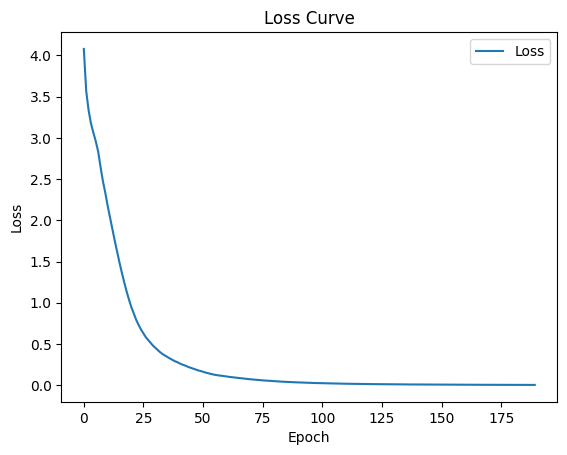

In [9]:
# Initialize lists to store loss values
loss_history = []

# Training loop
for epoch in range(190):  # Adjust the number of epochs as needed
    # Forward pass: compute predictions
    ypred = [n(x) for x in xs]

    # Compute loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss_history.append(loss.data)  # Store the loss value

    # Backward pass: compute gradients
    loss.backward()

    # Update weights
    for p in n.parameters():
        p.data -= 0.01 * p.grad  # Learning rate of 0.01

    # Zero the gradients for the next iteration
    for p in n.parameters():
        p.grad = 0.0

# Plot the loss curve
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

## Implementation on Wine Dataset

In [10]:
from sklearn.datasets import load_wine

# Load the dataset
wine = load_wine()

# Features (Xs)
X = wine.data  # Shape: (178, 13)

# Target labels (ys)
y = wine.target  # Shape: (178,)

# Feature names
feature_names = wine.feature_names  # List of 13 feature names

# Class names
class_names = wine.target_names  # List of 3 class names

In [11]:
feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [12]:
class_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [13]:
# Compute mean and standard deviation for each feature
mean = np.mean(X, axis=0)  # Mean of each column (feature)
std = np.std(X, axis=0)    # Standard deviation of each column (feature)

# Standardize the features
X_scaled = (X - mean) / std

In [14]:
# Compute mean and standard deviation of X_scaled
mean_scaled = np.mean(X_scaled, axis=0)  # Mean of each feature
std_scaled = np.std(X_scaled, axis=0)    # Standard deviation of each feature

# Print the results
print("Mean of X_scaled (should be close to 0):")
print(mean_scaled)

print("\nStandard Deviation of X_scaled (should be close to 1):")
print(std_scaled)

Mean of X_scaled (should be close to 0):
[ 7.84141790e-15  2.44498554e-16 -4.05917497e-15 -7.11041712e-17
 -2.49488320e-17 -1.95536471e-16  9.44313292e-16 -4.17892936e-16
 -1.54059038e-15 -4.12903170e-16  1.39838203e-15  2.12688793e-15
 -6.98567296e-17]

Standard Deviation of X_scaled (should be close to 1):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
# One hot encoding the targets

# Number of classes
num_classes = len(np.unique(y))

# Initialize a matrix of zeros with shape (num_samples, num_classes)
y_one_hot = np.zeros((len(y), num_classes))

# Fill the matrix with 1s at the appropriate positions
y_one_hot[np.arange(len(y)), y] = 1

# Print the first 5 rows of the one-hot encoded targets
print("One-Hot Encoded Targets (First 5 Rows):")
print(y_one_hot[:5])

One-Hot Encoded Targets (First 5 Rows):
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [21]:
# Set a random seed for reproducibility
np.random.seed(24)

# Shuffle the dataset
indices = np.arange(len(X))  # Create an array of indices
np.random.shuffle(indices)   # Shuffle the indices

# Split into training and testing sets
test_size = 0.2  # 20% of the data for testing
split_index = int(len(X) * (1 - test_size))  # Calculate the split index

# Split the features (X) and labels (y)
X_train, X_test = X_scaled[indices[:split_index]], X_scaled[indices[split_index:]]
y_train_one_hot , y_test = y_one_hot[indices[:split_index]], y_one_hot[indices[split_index:]]

y_train_one_hot = [[Value(ygt_i) for ygt_i in ygt] for ygt in y_train_one_hot] # Convert y_train to Value objects

In [22]:
X_train[0][0:5], y_train[0:5]

(array([-1.49543397, -0.18523128,  1.51142186,  2.70408323, -0.5435617 ]),
 array([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [24]:
model = MLP(13, [16, 16, 3]) # Define the MLP model with the number of features (13), hidden layers (2x16), classes (3)

Epoch 10, Loss: 3.752165721274365, Learning Rate: 0.01
Reduced learning rate to 0.001 at epoch 11
Epoch 20, Loss: 3.121130300927703, Learning Rate: 0.001
Reduced learning rate to 0.0001 at epoch 21
Epoch 30, Loss: 3.0704226133278665, Learning Rate: 0.0001
Reduced learning rate to 1e-05 at epoch 31
Epoch 40, Loss: 3.0654627887694534, Learning Rate: 1e-05


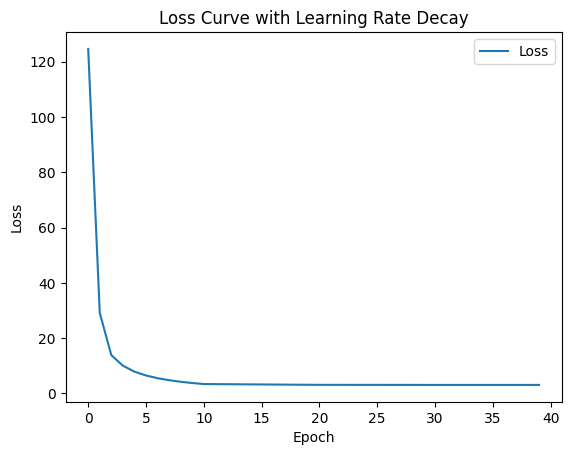

In [25]:
# Training loop
num_epochs = 40
learning_rate = 0.01
decay_rate = 0.1  # Reduce learning rate by 10x
decay_epochs = 10  # Reduce learning rate every 30 epochs
loss_history = []

for epoch in range(num_epochs):
    # Reduce learning rate every `decay_epochs` epochs
    if epoch > 0 and epoch % decay_epochs == 0:
        learning_rate *= decay_rate
        print(f"Reduced learning rate to {learning_rate} at epoch {epoch + 1}")

    # Forward pass: compute predictions
    ypred = [model(x) for x in X_train]  # Ensure model(x) returns a Value object

    # Compute loss (mean squared error) using Value objects
    loss = sum(sum((yout_i - ygt_i)**2 for yout_i, ygt_i in zip(yout, ygt)) for ygt, yout in zip(y_train_one_hot, ypred)) / len(y_train)
    loss_history.append(loss.data)

    # Backward pass: compute gradients
    loss.backward()  # Now loss is a Value object, so this works

    # Update weights with the current learning rate
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    # Zero the gradients for the next iteration
    for p in model.parameters():
        p.grad = 0.0

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.data}, Learning Rate: {learning_rate}")

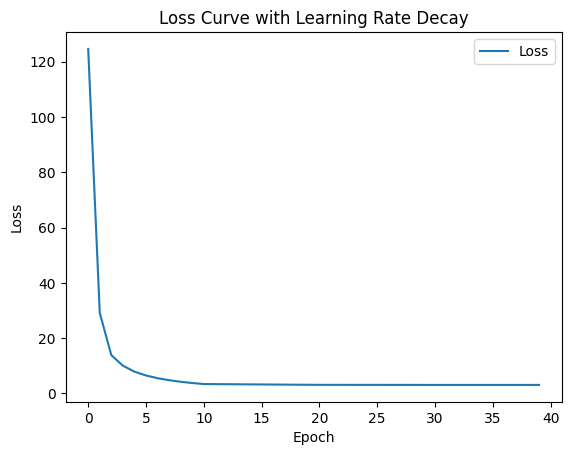

In [26]:
# Plot the loss curve
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve with Learning Rate Decay")
plt.legend()
plt.show()

Test Accuracy: 50.00%


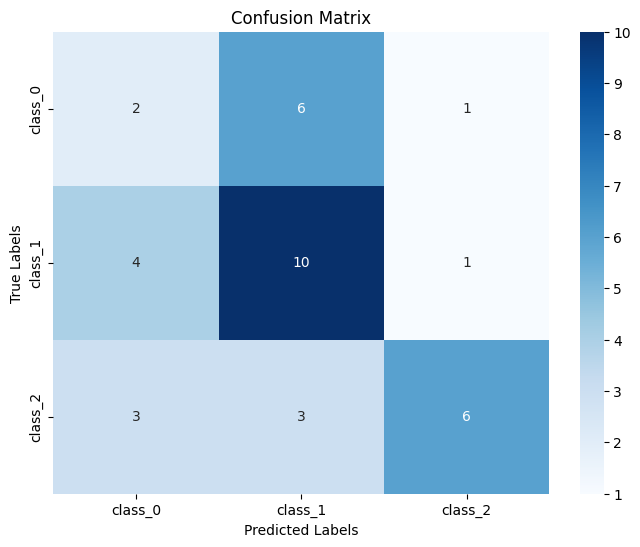

Classification Report:
              precision    recall  f1-score   support

     class_0       0.22      0.22      0.22         9
     class_1       0.53      0.67      0.59        15
     class_2       0.75      0.50      0.60        12

    accuracy                           0.50        36
   macro avg       0.50      0.46      0.47        36
weighted avg       0.52      0.50      0.50        36



In [30]:
# Make predictions on the test set
ypred_test = [model(x) for x in X_test]

# Extract .data from nested lists of Value objects
ypred_test_data = [[y_i.data for y_i in y] for y in ypred_test]

# Convert to NumPy array
ypred_test_data = np.array(ypred_test_data)

# Convert predictions to class labels
ypred_test_labels = np.argmax(ypred_test_data, axis=1)

# Convert y_test from one-hot encoded to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Compute accuracy
accuracy = np.mean(ypred_test_labels == y_test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_labels, ypred_test_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=wine.target_names, yticklabels=wine.target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Compute classification report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_labels, ypred_test_labels, target_names=wine.target_names))